# Project Overview and Scope

Sarcasm detection in Reddit comments lies in the domain of sentiment analysis and is treated as a binary classification problem since we have two distinct classes in our data. Sarcastic comment are labelled as 1 and non-sarcastic comments as 0. The aim of this project is to build a machine learning pipeline which includes:

1. Data Analysis
2. Data Preprocessing
3. Feature Engineering
4. Model Training
5. Optimization

The end product will be a trained model which would be able to generalize what it has learned on new data and distinguish between sarcastic and non-sarcastic comments with high accuracy.

In [1]:
# import libraries
import pandas as pd
import numpy as np
from scipy.sparse import hstack
from gensim.models import Word2Vec 
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import xgboost
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from nltk.corpus import stopwords
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import plot_confusion_matrix
import pickle
warnings.filterwarnings('ignore')

### 1. Data Analysis

In [10]:
# load dataset
file = 'train-balanced-sarcasm.csv'
df = pd.read_csv(file)
print('Dimensions of total data:', df.shape)

Dimensions of total data: (1010826, 10)


In [11]:
# pick a subset of entire data to test the pipeline
subset_ratio = 0.05
subset_df = df[:int(df.shape[0] * subset_ratio)]
print('Dimensions of subset:', subset_df.shape)

Dimensions of subset: (50541, 10)


In [12]:
# print first 5 rows of data
subset_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [13]:
# some info about numerical features
subset_df.describe()

,label,score,ups,downs
count,50541.000000,50541.000000,50541.000000,50541.000000
mean,0.412042,8.148098,0.938881,-0.782711
std,0.492207,48.378999,19.927624,0.412405
min,0.000000,-188.000000,-85.000000,-1.000000
25%,0.000000,1.000000,-1.000000,-1.000000
50%,0.000000,2.000000,-1.000000,-1.000000
75%,1.000000,5.000000,-1.000000,-1.000000
max,1.000000,3192.000000,1737.000000,0.000000


In [14]:
# info about the dataset
subset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50541 entries, 0 to 50540
Data columns (total 10 columns):
label             50541 non-null int64
comment           50541 non-null object
author            50541 non-null object
subreddit         50541 non-null object
score             50541 non-null int64
ups               50541 non-null int64
downs             50541 non-null int64
date              50541 non-null object
created_utc       50541 non-null object
parent_comment    50541 non-null object
dtypes: int64(4), object(6)
memory usage: 3.9+ MB


In [15]:
# check if there are any missing values in data
print('Missing values in data:', subset_df.isnull().values.any())

Missing values in data: False


In [16]:
# print total no. of missing values with respect to each column
subset_df.isnull().sum()

label             0
comment           0
author            0
subreddit         0
score             0
ups               0
downs             0
date              0
created_utc       0
parent_comment    0
dtype: int64

In [17]:
# since the number of rows with missing data is very small, we'll just go ahead and drop them
data = subset_df.dropna()
print('No. of rows before removing missing vals:', subset_df.shape[0])
print('No. of after removing missing vals:', data.shape[0])
print('No. of rows removed:', subset_df.shape[0] - data.shape[0])

No. of rows before removing missing vals: 50541
No. of after removing missing vals: 50541
No. of rows removed: 0


In [18]:
# check the distribution of sarcastic vs. non-sarcastic comments
print('No. of Non-sarcastic comments(0):', data[data['label'] == 0].shape[0])
print('No. of Sarcastic comments(1):', data[data['label'] == 1].shape[0])

No. of Non-sarcastic comments(0): 29716
No. of Sarcastic comments(1): 20825


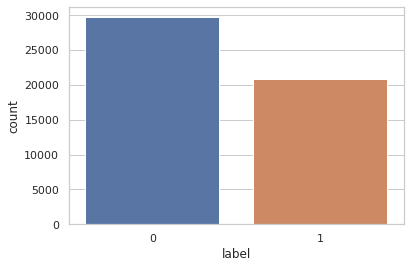

In [19]:
# visualize distribution of sarcastic vs. non-sarcastic comments
ax = sns.countplot(x="label", data=data)

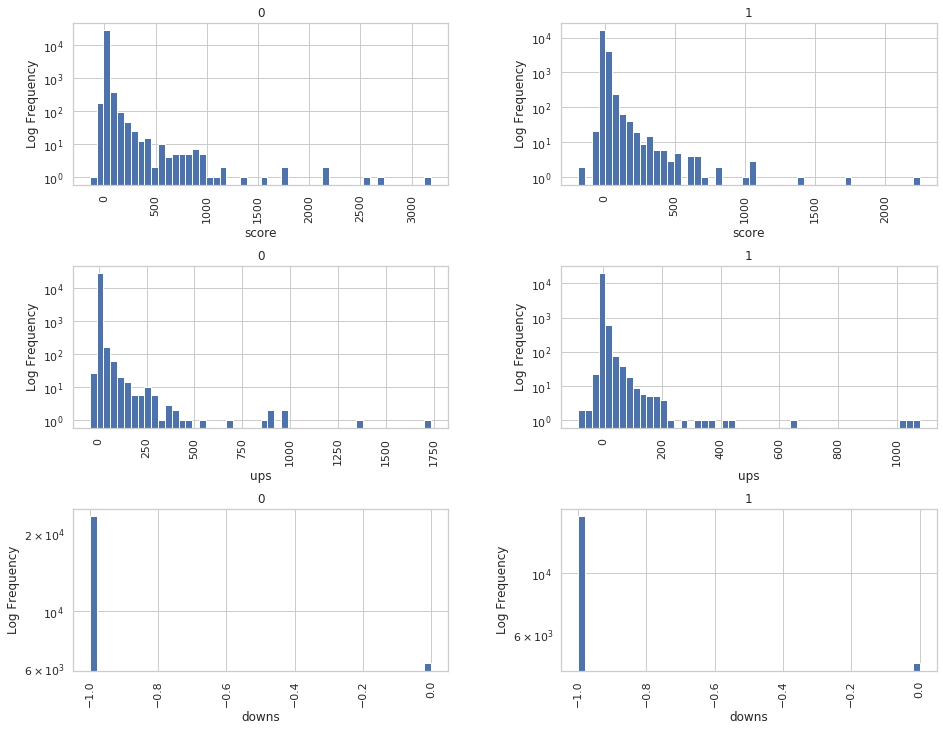

In [12]:
# frequency distribution of numeric features
fig, ax = plt.subplots(nrows=3, ncols=2, squeeze=False, figsize=(15, 12))
cols = ['score', 'ups', 'downs']

for i, row in enumerate(ax):
    axes = row.flatten()
    data.hist(ax=axes, column=cols[i], by='label', bins=50, log=True)

    axes[0].set_xlabel(cols[i])
    axes[0].set_ylabel('Log Frequency')

    axes[1].set_xlabel(cols[i])
    axes[1].set_ylabel('Log Frequency')


### 2. Data Preprocessing

In [13]:
# basic text preprocessing of data
cols = ['comment', 'subreddit', 'parent_comment']
stemmer = PorterStemmer()
stopwords = stopwords.words('english')

for c in cols:
    # remove special characters
    data[c] = data[c].map(lambda x: re.sub(r'\W', ' ', x))

    # replace multiple spaces with single space 
    data[c] = data[c].map(lambda x: re.sub(r'\s+', ' ', x, flags=re.I))

    # remove all single characters
    data[c] = data[c].map(lambda x:re.sub(r'\s+[a-zA-Z]\s+', ' ', x))

    # covert text to lower case
    data[c] = data[c].str.lower()

    # tokenize text
    data[c] = data[c].str.split()

    # apply stemming
    data[c] = data[c].map(lambda x: ' '.join([stemmer.stem(w) for w in x if w not in stopwords]))

### 3a. Feature Engineering using TF-IDF Vectorization

***term frequency:*** number of times a term has occured in a comment(document)<br>
***inverse document frequency:*** ivnerse frequency of number of comments in which term occured 

In [20]:
# generate tf-idf vectors for comment column 
tfidf_comment = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
comment_features_tfidf = tfidf_comment.fit_transform(data['comment'])

In [24]:
comment_features_tfidf.shape

(50541, 50000)

In [21]:
# generate tf-idf vectors for subreddit column 
tfidf_subreddit = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
subreddit_features_tfidf = tfidf_subreddit.fit_transform(data['subreddit'])

In [26]:
subreddit_features_tfidf.shape

(50541, 4047)

In [23]:
# generate tf-idf vectors for parent_comment column 
tfidf_parent_comment = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
parent_comment_features_tfidf = tfidf_parent_comment.fit_transform(data['parent_comment'])

In [27]:
parent_comment_features_tfidf.shape

(50541, 50000)

In [17]:
# standardize continous variables
scaler = StandardScaler()
score = scaler.fit_transform(data[['score', 'ups', 'downs']]) 

In [18]:
# stack up all the sparse features matrices horrizontally 
y_tfidf = data['label']
X_tfidf = hstack([comment_features_tfidf, subreddit_features_tfidf, parent_comment_features_tfidf, score])
print(X_tfidf.shape, y_tfidf.shape)

(50541, 104033) (50541,)


In [19]:
# train test split
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y_tfidf, test_size=0.2, random_state=0)
print("Dimensions of train set with TF-IDF Features", X_train_tfidf.shape)
print("Dimensions of validation set with TF-IDF Features", X_test_tfidf.shape)

Dimensions of train set with TF-IDF Features (40432, 104033)
Dimensions of validation set with TF-IDF Features (10109, 104033)


### 3b. Feature Engineering with Word2Vec

In [20]:
# this function takes an average of the word embeddings for each word in a comment/doc
def avg_word_embedding(comment, vocab, model, num_features):
    feat_vec = np.zeros((num_features,),dtype="float64")
    num_words = 0
    for word in comment:
        if word in vocab:
            feat_vec = np.add(feat_vec, model[word])
            num_words += 1

        if num_words:
            feat_vec /= num_words

    return feat_vec

In [21]:
# train word2vec model on comment feature
num_features = 500
corpus = data['comment'].values.tolist()
model = Word2Vec(sentences=corpus, size=num_features, window=5, workers=4, min_count=1)

# get vocab from model
vocab = list(model.wv.index2word)

# generate feature vector for each comment in the data
comment_features_word2vec = np.array([avg_word_embedding(comment, vocab, model, num_features) for comment in corpus])

In [22]:
# train word2vec model on subreddit feature
num_features = 500
corpus = data['subreddit'].values.tolist()
model = Word2Vec(sentences=corpus, size=num_features, window=5, workers=4, min_count=1)

# get vocab from model
vocab = list(model.wv.index2word)

# generate feature vector for each subreddit in the data
subreddit_features_word2vec = np.array([avg_word_embedding(comment, vocab, model, num_features) for comment in corpus])

In [23]:
# train word2vec model on parent_comment feature
num_features = 500
corpus = data['parent_comment'].values.tolist()
model = Word2Vec(sentences=corpus, size=num_features, window=5, workers=4, min_count=1)

# get vocab from model
vocab = list(model.wv.index2word)

# generate feature vector for each parent_comment in the data
parent_comment_features_word2vec = np.array([avg_word_embedding(comment, vocab, model, num_features) for comment in corpus])

In [24]:
# stack up all the sparse features matrices horrizontally 
y_word2vec = data['label']
X_word2vec = np.hstack([comment_features_word2vec, subreddit_features_word2vec, parent_comment_features_word2vec, score])
print(X_word2vec.shape, y_word2vec.shape)

(50541, 1503) (50541,)


In [25]:
# train test split
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(X_word2vec, y_word2vec, test_size=0.2, random_state=0)
print("Dimensions of train set with word2vec features:", X_train_word2vec.shape)
print("Dimensions of validation set with word2vec features:", X_test_word2vec.shape)

Dimensions of train set with word2vec features: (40432, 1503)
Dimensions of validation set with word2vec features: (10109, 1503)


### 4a Training Logistic Regression with TF-IDF Features

In [26]:
# train logitic regression classifier
lr_tfidf = LogisticRegression()
lr_tfidf.fit(X_train_tfidf, y_train_tfidf) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
# print traing and test set accuracies
print("Model Accuracy on Training Set:", round(accuracy_score(y_train_tfidf, lr_tfidf.predict(X_train_tfidf)), 3))
print("Model Accuracy on Test Set:", round(accuracy_score(y_test_tfidf, lr_tfidf.predict(X_test_tfidf)), 3))

Model Accuracy on Training Set: 0.854
Model Accuracy on Test Set: 0.67


In [28]:
# make predictions on test set and print performance metrics
print("Classification Report on Test Set:\n")
print(classification_report(y_test_tfidf, lr_tfidf.predict(X_test_tfidf)))

Classification Report on Test Set:

              precision    recall  f1-score   support

           0       0.69      0.81      0.74      5975
           1       0.63      0.47      0.54      4134

    accuracy                           0.67     10109
   macro avg       0.66      0.64      0.64     10109
weighted avg       0.66      0.67      0.66     10109



In [ ]:
Precision = TP / (TP + FP)
ratio of correctly classified points of interest(sarcastic comments)
Recall = TP / TP + FN
ability of model to find points of interest (sarcastic comments) in the data

### 4b.SVM with TF-IDF Vectorization

In [36]:
# train svm
svm_tfidf = svm.SVC()
svm_tfidf.fit(X_train_tfidf, y_train_tfidf)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [37]:
# print accuracy on train and test sets
print("Model Accuracy on Training Set:", round(accuracy_score(y_train_tfidf, svm_tfidf.predict(X_train_tfidf)), 3))
print("Model Accuracy on Test Set:", round(accuracy_score(y_test_tfidf, svm_tfidf.predict(X_test_tfidf)), 3))

Model Accuracy on Training Set: 0.846
Model Accuracy on Test Set: 0.844


In [38]:
# make predictions on test set and print performance metrics
print("Classification Report on Test Set:\n")
print(classification_report(y_test_tfidf, svm_tfidf.predict(X_test_tfidf)))

Classification Report on Test Set:

              precision    recall  f1-score   support

           0       0.80      0.97      0.88      5975
           1       0.94      0.66      0.77      4134

    accuracy                           0.84     10109
   macro avg       0.87      0.81      0.83     10109
weighted avg       0.86      0.84      0.84     10109



### 4c. Training Logistic Regression with Word2Vec Features 

In [29]:
# train classifier
lr_word2vec = LogisticRegression()
lr_word2vec.fit(X_train_word2vec, y_train_word2vec) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
print("Model Accuracy on Training Set:", round(accuracy_score(y_train_word2vec, lr_word2vec.predict(X_train_word2vec)), 3))
print("Model Accuracy on Test Set:", round(accuracy_score(y_test_word2vec, lr_word2vec.predict(X_test_word2vec)), 3))

Model Accuracy on Training Set: 0.591
Model Accuracy on Test Set: 0.595


In [32]:
# make predictions on test set and print performance metrics
print("Classification Report on Test Set:\n")
print(classification_report(y_test_word2vec, lr_word2vec.predict(X_test_word2vec)))

Classification Report on Test Set:

              precision    recall  f1-score   support

           0       0.60      0.98      0.74      5975
           1       0.60      0.03      0.06      4134

    accuracy                           0.60     10109
   macro avg       0.60      0.51      0.40     10109
weighted avg       0.60      0.60      0.46     10109



### 4d. Training SVM with Word2Vec Features

In [34]:
# train classifier
svm_word2vec = svm.SVC()
svm_word2vec.fit(X_train_word2vec, y_train_word2vec) 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [35]:
print("Model Accuracy on Training Set:", round(accuracy_score(y_train_word2vec, svm_word2vec.predict(X_train_word2vec)), 3))
print("Model Accuracy on Test Set:", round(accuracy_score(y_test_word2vec, svm_word2vec.predict(X_test_word2vec)), 3))

Model Accuracy on Training Set: 0.589
Model Accuracy on Test Set: 0.592


In [36]:
# make predictions on test set and print performance metrics
print("Classification Report on Test Set:\n")
print(classification_report(y_test_word2vec, svm_word2vec.predict(X_test_word2vec)))

Classification Report on Test Set:

              precision    recall  f1-score   support

           0       0.59      1.00      0.74      5975
           1       0.62      0.00      0.01      4134

    accuracy                           0.59     10109
   macro avg       0.61      0.50      0.38     10109
weighted avg       0.60      0.59      0.44     10109

